# Set up

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cd89106ac91cd97200d2e52200630d2544e60fc808b751f01ee9c3e444b8d12b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=b85b0d43fb4a900e8b3145bfd3d34376fb6e9dfbd86adbb87feda3633f9b6a06
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (3/3), done.


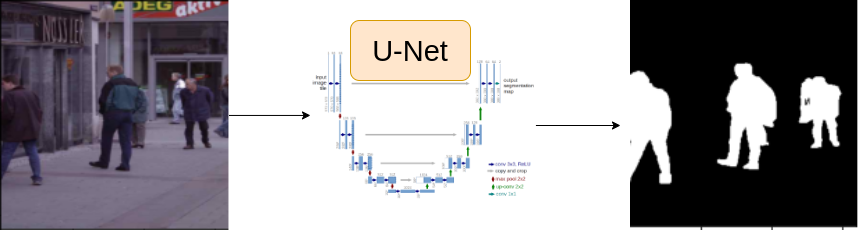

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
EPOCHS =25
LR = 0.003
IMAGE_SIZE = 256

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

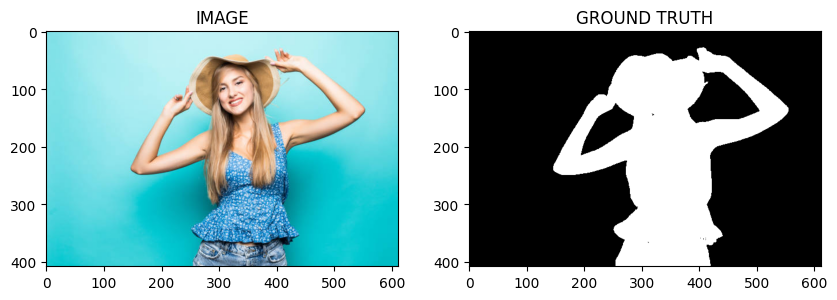

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ], is_check_shapes=False)

# Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        row = self.df.iloc[index]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)


        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return (image, mask)


In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


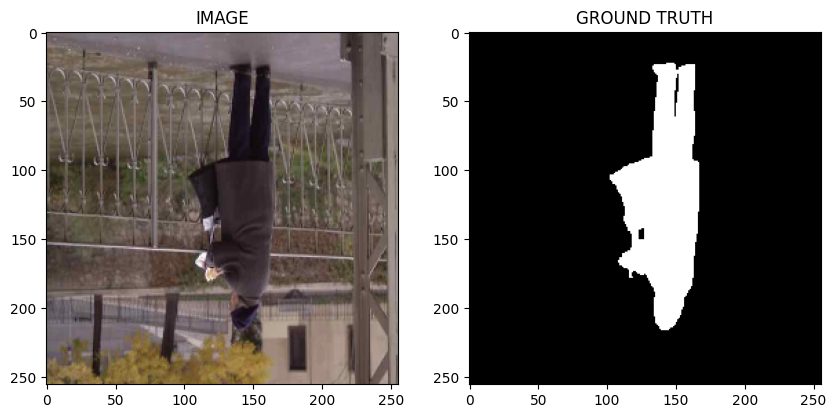

In [17]:
idx = 4

image, mask = trainset[idx]

helper.show_image(image, mask)

# Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
BATCH_SIZE = 16

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [21]:
print(F'tOTAL NUMBER OF BATCHES IN TRAINLOADER : {len(trainloader)}')
print(F'tOTAL NUMBER OF BATCHES IN VALIDLOADER : {len(validloader)}')

tOTAL NUMBER OF BATCHES IN TRAINLOADER : 15
tOTAL NUMBER OF BATCHES IN VALIDLOADER : 4


In [22]:
for image, mask in trainloader:
    break

In [23]:
print(f"One batch image shape : {image.shape}")
print(f"One batch mask : {mask.shape}")

One batch image shape : torch.Size([16, 3, 256, 256])
One batch mask : torch.Size([16, 1, 256, 256])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [51]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )


    def forward(self, images, masks = None):

        logits = self.arc(images)

        if mask != None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits

In [30]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 72.6MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Create Train and Validation Function

In [31]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in data_loader:

        images= images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [35]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in data_loader:

            images= images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss/len(data_loader)

# Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [36]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)


    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1}  Train Loss : {train_loss} Valid_loss : {valid_loss}")


SAVED-MODEL
Epoch : 1  Train Loss : 0.3694757392009099 Valid_loss : 0.4291057139635086
SAVED-MODEL
Epoch : 2  Train Loss : 0.30668784280618033 Valid_loss : 0.3083479143679142
Epoch : 3  Train Loss : 0.26961648563543955 Valid_loss : 0.3237885646522045
SAVED-MODEL
Epoch : 4  Train Loss : 0.22942880590756734 Valid_loss : 0.25743966922163963
SAVED-MODEL
Epoch : 5  Train Loss : 0.22077945371468863 Valid_loss : 0.2384229116141796
Epoch : 6  Train Loss : 0.22795370519161223 Valid_loss : 0.26659298688173294
Epoch : 7  Train Loss : 0.2130802422761917 Valid_loss : 0.269699040800333
Epoch : 8  Train Loss : 0.1850761483112971 Valid_loss : 0.2410474233329296
SAVED-MODEL
Epoch : 9  Train Loss : 0.1898053452372551 Valid_loss : 0.23245550319552422
SAVED-MODEL
Epoch : 10  Train Loss : 0.16421811878681183 Valid_loss : 0.2252686470746994
SAVED-MODEL
Epoch : 11  Train Loss : 0.15173271199067434 Valid_loss : 0.17686626687645912
Epoch : 12  Train Loss : 0.1515919049580892 Valid_loss : 0.1941649727523327
Epo

# Inference

In [45]:
validset[0]

(tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.6706, 0.6706, 0.6706],
          [0.1765, 0.1765, 0.1765,  ..., 0.6706, 0.6706, 0.6706],
          [0.1686, 0.1686, 0.1686,  ..., 0.6706, 0.6706, 0.6706],
          ...,
          [0.5255, 0.5255, 0.5255,  ..., 0.4980, 0.4980, 0.5020],
          [0.5255, 0.5255, 0.5255,  ..., 0.4824, 0.4784, 0.4784],
          [0.5255, 0.5255, 0.5255,  ..., 0.4980, 0.4745, 0.4588]],
 
         [[0.1451, 0.1451, 0.1451,  ..., 0.5412, 0.5412, 0.5412],
          [0.1569, 0.1569, 0.1569,  ..., 0.5412, 0.5412, 0.5412],
          [0.1490, 0.1490, 0.1490,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5569, 0.5569, 0.5569,  ..., 0.4902, 0.4902, 0.4941],
          [0.5569, 0.5569, 0.5569,  ..., 0.4627, 0.4627, 0.4588],
          [0.5569, 0.5569, 0.5569,  ..., 0.4784, 0.4549, 0.4392]],
 
         [[0.1294, 0.1294, 0.1294,  ..., 0.5137, 0.5137, 0.5137],
          [0.1412, 0.1412, 0.1412,  ..., 0.5137, 0.5137, 0.5137],
          [0.1333, 0.1333, 0.1333,  ...,

In [46]:
image, mask = validset[2]

In [52]:
model.load_state_dict(torch.load('/content/best_model.pt'))

<All keys matched successfully>

In [57]:
image = image.to(DEVICE).unsqueeze(0)

In [74]:
image.shape

torch.Size([1, 3, 256, 256])

In [60]:
mask = mask.to(DEVICE).unsqueeze(0)

In [62]:
logits_mask = model(image, mask)

In [64]:
logits_mask

(tensor([[[[-2.5114e+00, -4.0505e+00, -4.1028e+00,  ..., -1.3311e+00,
            -1.5433e+00, -1.4952e+00],
           [-4.3886e+00, -6.6256e+00, -6.6947e+00,  ..., -2.4647e+00,
            -2.8140e+00, -2.2781e+00],
           [-4.4834e+00, -6.6717e+00, -6.6122e+00,  ..., -2.0314e+00,
            -2.4780e+00, -2.1964e+00],
           ...,
           [-3.6176e+00, -5.0169e+00, -4.5214e+00,  ...,  8.3051e-01,
            -5.1045e-01, -1.3368e+00],
           [-3.4254e+00, -4.9015e+00, -4.5392e+00,  ..., -5.0389e-03,
            -1.1799e+00, -1.8078e+00],
           [-2.5163e+00, -3.1065e+00, -2.9465e+00,  ..., -5.2703e-01,
            -1.3902e+00, -1.2782e+00]]]], device='cuda:0',
        grad_fn=<ConvolutionBackward0>),
 tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>))

In [70]:
logits_mask[0].shape

torch.Size([1, 1, 256, 256])

In [65]:
pred_mask = torch.sigmoid(logits_mask[0])

In [66]:
pred_mask = (pred_mask >0.5) * 1

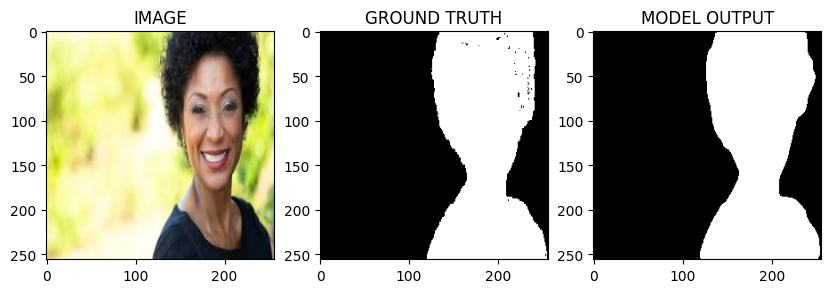

In [75]:
helper.show_image(image.detach().cpu().squeeze(0), mask.detach().cpu().squeeze(0), pred_mask.detach().cpu().squeeze(0))